0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

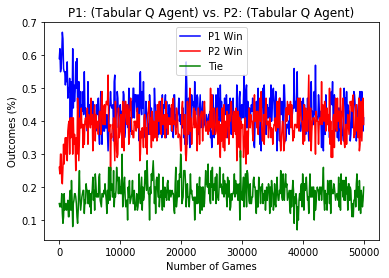

In [17]:
import random
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

class TicTacToe():
    
    def __init__(self):
        self.state = '---------'

    # Resets the game
    def reset_game(self):
        self.state = '---------'

    # Check if game over
    def game_over(self):

        # Check if there are any possible moves
        if '-' in self.state:
            return None
        
        # Each list corresponds to the values to check to see if a winner is there
        checks = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7] , [2, 5, 8], [0, 4, 8], [2, 4, 6]]
        for check in checks:
            # Check to see if the strings have a winner
            test = self.state[check[0]] + self.state[check[1]] + self.state[check[2]]
            if test == 'XXX':
                return 'X'
            elif test == 'OOO':
                return 'O'
        
        # Return tie in the last case
        return 'T'

    # Does a move given an action (number) and a piece
    def play_move(self, move, ID):

        # Return false if illegal move 
        if self.state[move] != '-':
            return False

        # Plays a move depending on what number is fed in
        self.state = self.state[:move] + ID + self.state[move+1:]

        # Return true if legal move
        return True

    # Gets the reward via ID
    def get_reward(self, result, ID):

        # No reward for a non-game ending state
        if result == 'T':
            return 0
        elif result == ID:
            return 1
        else:
            return -1

    # Trains a bot against a random player
    def train(self, a_1, a_2, batch):

        # Exit if the same ID
        if a_1.ID == a_2.ID:
            return

        # Store total wins
        a_1_wins = 0
        a_1_ties = 0

        # Train on 1000 games per session
        for i in range(batch):

            # Store the result
            result = None

            # Make a turn variable to see who's it is
            turn = 'X'

            # Each game is at most 9 turns
            for i in range(9):

                # Play moves
                if a_1.ID == turn:

                    # Get move and play move
                    move = a_1.get_move(self.state)
                    self.play_move(move, a_1.ID)

                    # Flip turn
                    turn = 'O'

                    # Check game over
                    result = self.game_over()
                    if (result != None):
                        break

                else:
                    # Do random move for other player
                    move = a_2.get_move(self.state)
                    self.play_move(move, a_2.ID)

                    # Flip turn
                    turn = 'X'

                    # Check game over
                    result = self.game_over()
                    if (result != None):
                        break

            # Update if game over
            if result != None:
                a_1.calculate(self.get_reward(result, a_1.ID))
                a_2.calculate(self.get_reward(result, a_2.ID))
                a_1.reset()
                a_2.reset()
                self.reset_game()

                # Add one to wins if won
                if result == a_1.ID:
                    a_1_wins += 1
                elif result == 'T':
                    a_1_ties += 1

        return (a_1_wins, a_1_ties)


# Superclass for aribtrary agent
class Agent:

    def __init__(self, ID, name):
        self.ID = ID
        self.name = name

    # Called to get the next move
    @abstractmethod
    def get_move(self, state):
        pass

    # Called at the end of each game to calculate parameters
    @abstractmethod
    def calculate(self, result):
        pass

    # Called to reset the agent
    @abstractmethod
    def reset(self):
        pass

class Random(Agent):

    def __init__(self, ID):
        # Call superconstructor
        super().__init__(ID, 'Random Agent')

    def get_move(self, state):
        return random.choice([i for i in range(9) if state[i] == '-'])

    def calculate(self, result):
        return

    def reset(self):
        return

class Neural_Q_Agent(Agent):

    def __init__(self, ID):
        # Call superconstructor
        super().__init__(ID, 'Neural Q Agent')

    def get_move(self, state):
        return random.choice([i for i in range(9) if state[i] == '-'])

    def calculate(self, result):
        return

    def reset(self):
        return

class Tabular_Q_Agent(Agent):

    def __init__(self, ID, random=False): 

        # Call superconstructor
        super().__init__(ID, 'Tabular Q Agent')

        # State sets, stored as dictionary
        self.states = {}
        self.alpha = 0.9
        self.discount = 0.96
        self.init = 0.6
        self.recorded_states = []

        # For gathering data
        self.gather_data = False
        self.training = []
        self.labels = []

    # For a new game
    def reset(self):
        self.recorded_states = []

    # Calculate stuff for training
    def neural_net_calc(self, result):

        self.recorded_states.reverse()

        # Flag for the first time
        first = True
        maximum = 0

        # For the first case, we just use the reward
        for state in self.recorded_states:

            # Test these three characters
            text = ['X', 'O', '-']
            res = []
            for char in text:
                if state[i] == char:
                    res.training.append(1)
                else:
                    res.training.append(0)

            # Add the list to the training data 
            self.training.append(res)

            # Do special update if first
            if first:
                # Set the win condition to 1
                self.states[state[0]][state[1]] = reward
                first = False
            else:
                if self.gather_data:

                    self.states[state[0]][state[1]] = (1 - self.alpha) * self.states[state[0]][state[1]] + self.alpha *  self.discount * maximum

            # Store the previous max
            maximum = max(self.states[state[0]])


    # Updates the policy
    def calculate(self, reward):

        # Skip this if we're just gathering data
        if self.gather_data:
            return

        # Iterate through the states
        self.recorded_states.reverse()

        # Flag for the first time
        first = True
        maximum = 0

        # For the first case, we just use the reward
        for state in self.recorded_states:

            # Do special update if first
            if first:
                # Set the win condition to 1
                self.states[state[0]][state[1]] = reward
                first = False
            else:
                if self.gather_data:

                    self.states[state[0]][state[1]] = (1 - self.alpha) * self.states[state[0]][state[1]] + self.alpha * self.discount * maximum

            # Store the previous max
            maximum = max(self.states[state[0]])

    # Get q-value list for a key with lazy initialization
    def get_q(self, state):
        
        # If the key is there return it
        if state in self.states:
            return self.states[state]
        # Otherwise initialize it and set illegal moves to -Inf
        else:
            res = []
            # Initialize the array with -inf for values that are illegal
            for i in range(9):
                if state[i] == '-':
                    res.append(self.init)
                else:
                    res.append(float('-inf'))

            self.states[state] = res
            return res

    # Generates possible states to move to
    def generate_moves(self, state, piece):
        
        # Create a list to store
        moves = []
        
        # Iterate through and add 'X' or 'O' wherever possible
        for i in range(9):
            if state[i] == '-':
                moves.append(state[:i] + piece + state[i+1:])

        return moves

    # Get an optimal move
    def get_move(self, state):


        # Get the q-values for this 
        q_vals = self.get_q(state)

        # Get location of all max values and select a random one
        max_q = max(q_vals)
        move = random.choice([i for i, j in enumerate(q_vals) if j == max_q])

        # Record a tuple of board state and index of move
        self.recorded_states.append((state, move))

        return move


# Initialize environment
p1 = Tabular_Q_Agent('X')
p2 = Tabular_Q_Agent('O')
t = TicTacToe()

# Store results
wins = []
ties = []
losses = []
count = []
batch = 100
for i in range (500):
    print(i)
    res = t.train(p1, p2, batch)
    wins.append(res[0] / batch)
    ties.append(res[1] / batch)
    losses.append((batch - res[0] - res[1]) / batch)
    count.append(batch * i)


# Print stuff for matplotlib
plt.ylabel('Outcomes (%)')
plt.xlabel('Number of Games')
plt.title('P1: ({}) vs. P2: ({})'.format(p1.name, p2.name))

plt.plot(count, wins, 'b-', label='P1 Win')
plt.plot(count, losses, 'r-', label='P2 Win')
plt.plot(count, ties, 'g-', label='Tie')
plt.legend(loc='best')
plt.show()

In [8]:
!pip3 install tic_tac_toe --user

In [9]:
!pip install tic_tac_toe.Board

ERROR: Could not find a version that satisfies the requirement tic_tac_toe.Board (from versions: none)
ERROR: No matching distribution found for tic_tac_toe.Board


In [20]:
p1.get_q


<bound method Tabular_Q_Agent.get_q of <__main__.Tabular_Q_Agent object at 0x0000017BAFCBEEF0>>